In [1]:
import os  # For interacting with the operating system (file paths, directories)
import numpy as np  # For numerical operations and handling arrays
import librosa  # For audio processing and feature extraction
import librosa.display  # For visualizing audio features
import tensorflow as tf  # For deep learning model implementation
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     Reshape, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D)
from tensorflow.keras.models import Sequential  # For defining sequential models
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For evaluating model performance

In [2]:
# Define constants for audio processing
AUDIO_SAMPLE_RATE = 22050  # Sampling rate for audio files (default for Librosa)
MAX_AUDIO_DURATION = 3  # Maximum duration (in seconds) of each audio clip
N_MELS = 128  # Number of Mel frequency bins for spectrogram extraction
FRAME_SIZE = 128  # Fixed size for time frames in the spectrogram
NUM_CLASSES = 2  # Number of output classes (real or fake audio)

In [3]:
# Define dataset directories
DATASET_PATH = "E:/capstone/Deep_Fake/dd_total"  # Base dataset path
REAL_PATH = os.path.join(DATASET_PATH, "real")  # Path for real audio files
FAKE_PATH = os.path.join(DATASET_PATH, "fake")  # Path for fake audio files

In [4]:
# Function to extract Mel spectrogram features from an audio file
def extract_features(file_path, max_duration=MAX_AUDIO_DURATION, sample_rate=AUDIO_SAMPLE_RATE, n_mels=N_MELS):
    try:
        # Load the audio file with the specified sample rate and duration
        audio, sr = librosa.load(file_path, sr=sample_rate, duration=max_duration)
        # Compute the Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        # Convert power spectrogram to decibel scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure a fixed shape (N_MELS, FRAME_SIZE) by padding or truncating
        if mel_spec_db.shape[1] < FRAME_SIZE:
            pad_width = FRAME_SIZE - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :FRAME_SIZE]

        return mel_spec_db  # Return the processed Mel spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")  # Print an error message if file processing fails
        return None  # Return None if processing fails

In [5]:
# Function to load dataset and extract features
def load_data():
    features, labels = [], []  # Initialize lists for storing features and labels

    # Iterate over both real and fake audio directories
    for label, path in [("real", REAL_PATH), ("fake", FAKE_PATH)]:
        for file_name in os.listdir(path):  # Loop through files in the directory
            file_path = os.path.join(path, file_name)  # Get full file path
            mel_spec = extract_features(file_path)  # Extract features
            if mel_spec is not None:
                features.append(mel_spec)  # Append extracted features
                labels.append(label)  # Append corresponding label

    return np.array(features, dtype=np.float32), np.array(labels)  # Convert to NumPy arrays and return


In [6]:
# Load and preprocess the dataset
X, y = load_data()
X = np.expand_dims(X, axis=-1)  # Expand dimensions to match CNN input shape (height, width, channels)

C:\Users\vuggi\AppData\Local\Temp\ipykernel_1680\2562098333.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=sample_rate, duration=max_duration)
c:\Users\vuggi\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing E:/capstone/Deep_Fake/dd_total\fake\file13424.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file15746.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file16643.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file17407.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file17450.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file19851.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file27206.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file27643.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file27839.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file30959.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file31017.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file32972.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file5323.mp3: 
Error processing E:/capstone/Deep_Fake/dd_total\fake\file9875.mp3: 


In [7]:
# Encode class labels into numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert string labels ('real', 'fake') into integers (0, 1)
y_encoded = tf.keras.utils.to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encode the labels

In [8]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [9]:
# Function to build the CNN-Transformer hybrid model
def build_transformer_model(input_shape=(128, 128, 1), num_classes=2):
    inputs = Input(shape=input_shape)  # Define input layer

    # CNN Feature Extractor
    x = Conv2D(32, (3, 3), activation='relu')(inputs)  # Convolutional layer with 32 filters
    x = MaxPooling2D((2, 2))(x)  # Max pooling to reduce spatial dimensions
    x = Conv2D(64, (3, 3), activation='relu')(x)  # Another convolutional layer with 64 filters
    x = MaxPooling2D((2, 2))(x)  # Max pooling again
    x = Flatten()(x)  # Flatten feature maps into a 1D array

    # Fully connected layer before Transformer
    x = Dense(256, activation='relu')(x)
    x = Reshape((2, 128))(x)  # Reshape to fit Transformer input format

    # Transformer Block
    x = LayerNormalization()(x)  # Normalize input for stability
    attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)  # Self-attention mechanism
    x = GlobalAveragePooling1D()(attention_output)  # Reduce dimensions

    # Fully Connected Layers
    x = Dropout(0.3)(x)  # Dropout to prevent overfitting
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.3)(x)  # Additional dropout layer
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation

    # Define and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model  # Return the compiled model

In [10]:
# Initialize and train the model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = build_transformer_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 351s 291ms/step - accuracy: 0.9178 - loss: 0.1939 - val_accuracy: 0.9936 - val_loss: 0.0221
Epoch 2/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 329s 279ms/step - accuracy: 0.9919 - loss: 0.0266 - val_accuracy: 0.9906 - val_loss: 0.0380
Epoch 3/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 327s 277ms/step - accuracy: 0.9953 - loss: 0.0140 - val_accuracy: 0.9967 - val_loss: 0.0096
Epoch 4/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 373s 316ms/step - accuracy: 0.9975 - loss: 0.0063 - val_accuracy: 0.9983 - val_loss: 0.0071
Epoch 5/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 362s 307ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9847 - val_loss: 0.0558
Epoch 6/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 366s 311ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9963 - val_loss: 0.0103
Epoch 7/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 359s 304ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9985 - val_loss: 0.0043
Epoch 8/10
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 360s 305ms/step - ac

In [11]:
# Evaluate the model performance
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels


506/506 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step


In [12]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

In [16]:
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
# Error Rate
error_rate = 1 - accuracy
print(f"Error Rate: {error_rate:.4f}")

Test Accuracy: 99.89%
Precision: 99.91%
Recall: 99.88%
F1 Score: 99.89%
Error Rate: 0.0011


506/506 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step


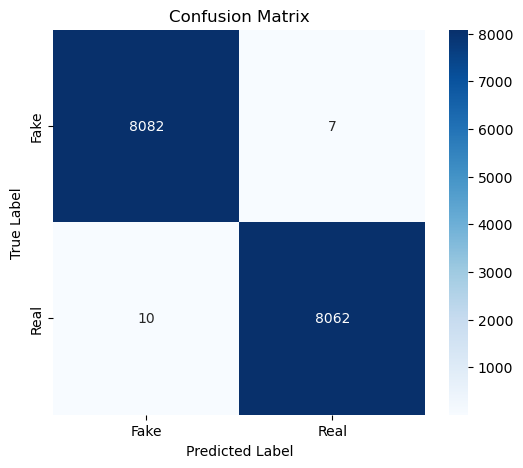

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      8089
        Real       1.00      1.00      1.00      8072

    accuracy                           1.00     16161
   macro avg       1.00      1.00      1.00     16161
weighted avg       1.00      1.00      1.00     16161



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get model predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))


In [15]:
model.save("audio_classification_model.h5")
print("Model saved as audio_classification_model.h5")

Model saved as audio_classification_model.h5
